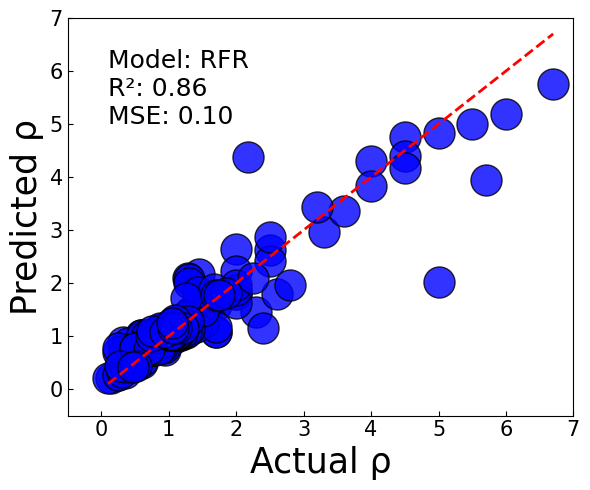

Using 323 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


  0%|          | 0/323 [00:00<?, ?it/s]

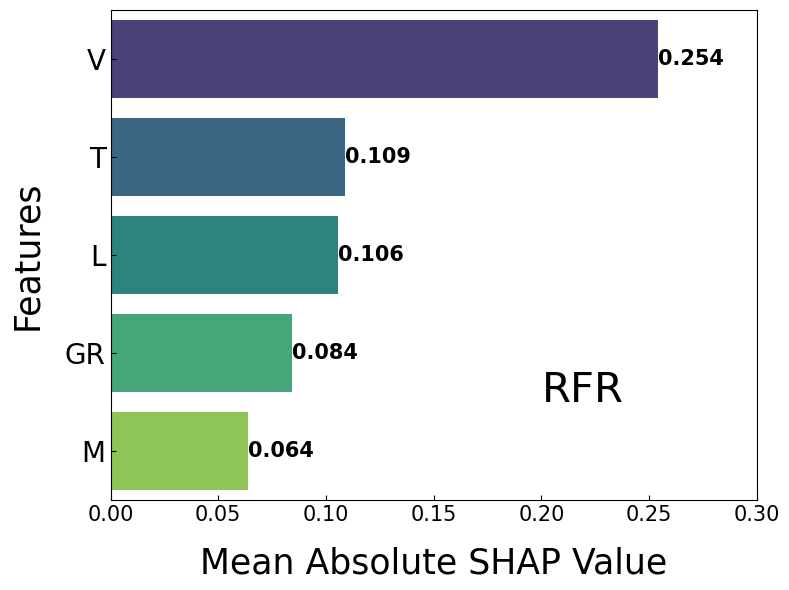

In [10]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb

# Load data
validate_data = pd.read_excel('Integrated dataset.xlsx')


# Data preprocessing
columns = ['metal', 'support', 'wt.%', 'solid electrolyte', 'ionic species', 'ionic species charge', 
           'particle size(nm)', 'metal loading (mg)', 'catalyst redox', 'CO2:H2 ratio', 'temp(℃)', 
           'rCO(mol/s)', 'voltage(V)', 'current(mA)', 'ρCO', 'ΛCO']

# Convert categorical data to numerical
# Validation data preprocessing
validate_data.columns = columns
validate_data['metal'] = validate_data['metal'].replace(['Fe','Co','Ni','Cu','ZnO','Ru','Rh','Pd','Pt'],
                                                        [55.8, 58.9, 58.7, 63.5, 65.4, 101.1, 102.9, 106.4, 195.1])
validate_data['wt.%'] = validate_data['wt.%'].fillna(100).astype(float)
validate_data['gas ratio'] = validate_data['CO2:H2 ratio'].apply(lambda x: int(x.split(':')[0]) / int(x.split(':')[1]))
validate_data = validate_data.drop('CO2:H2 ratio', axis=1)
validate_data.columns = ['M', 'S', 'WT', 'SE', 'IS', 'ISC', 'PS', 'L', 'CR', 'T', 'RR', 'V', 'C', 'ρ', 'Λ', 'GR']

#determine the ionic charge
ionic_charge = {
    'O2-': -2,
    'H+': 1,
    'Li+': 1,
    'Na+': 1,
    'K+': 1,
    'none': 0
}
validate_data['IS_charge'] = validate_data['IS'].replace(ionic_charge).fillna(0).astype(float)

def electro_class(row):
    if row['V'] > 0 and row['ρ'] >= 1:
        return 0
    elif row['V'] < 0 and row['ρ'] >= 1:
        return 1
    elif row['V'] > 0 and row['ρ'] <= 1:
        return 1
    elif row['V'] < 0 and row['ρ'] <= 1:
        return 0
    else:
        return 'undefined'

validate_data['BH'] = validate_data.apply(electro_class, axis=1)

# Feature and target selection
features = ['M', 'L', 'V', 'T', 'GR']
X_v = validate_data[features]
y_v = validate_data['ρ']

# Feature scaling
scaler = StandardScaler()
X_v_scaled = scaler.fit_transform(X_v)

RFR = RandomForestRegressor(n_estimators=10, max_depth=7, min_samples_split=2, random_state=0)
RFR.fit(X_v_scaled, y_v)
y_pred = RFR.predict(X_v_scaled)

# plot the scatters with RFR
mse = mean_squared_error(y_v, y_pred)
r2 = r2_score(y_v, y_pred)
    
fig = plt.figure(figsize=(6,5))
plt.scatter(y_v, y_pred, alpha=0.8, color='blue', edgecolors='k', s=500)
plt.plot([y_v.min(), y_v.max()], [y_v.min(), y_v.max()], 'r--', lw=2)
plt.xlabel('Actual ρ', size=25)
plt.ylabel('Predicted ρ', size=25)
plt.text(0.1, 5, f'Model: RFR\nR²: {r2:.2f}\nMSE: {mse:.2f}', fontsize=18)
plt.tick_params(direction='in', which='both', labelsize=15)

plt.xlim(-0.5, 7)
plt.ylim(-0.5, 7)
plt.xticks(np.arange(0, 7.1, 1))
plt.yticks(np.arange(0, 7.1, 1))

plt.tight_layout()
plt.savefig('Integrated Validate Scatter (RFR only).jpg', format='jpeg', dpi=600)
plt.show()

# feature importance for RFR
import shap
shap.initjs()
# Creating the KernelExplainer
RFR_explainer = shap.KernelExplainer(RFR.predict, X_v_scaled)
RFR_shap_values = RFR_explainer.shap_values(X_v_scaled)
# Generating the bar plot with mean SHAP values and feature names
# Calculate mean absolute SHAP values for each feature
mean_abs_shap_values = np.mean(np.abs(RFR_shap_values), axis=0)

# Create a DataFrame for plotting with SHAP values
importance_df = pd.DataFrame({'Feature': X_v.columns, 'Importance': mean_abs_shap_values})
importance_df = importance_df.sort_values(by='Importance', ascending=False)
# Plotting the feature importances with values
plt.figure(figsize=(8, 6))
sns.barplot(x='Importance', y='Feature', data=importance_df, palette='viridis')
# Adding the values on the bars
for index, value in enumerate(importance_df['Importance']):
    plt.text(value, index, f'{value:.3f}', va='center', ha='left', color='black', fontweight='bold', fontsize=15)

plt.xlim(0,0.3)
plt.xlabel('Mean Absolute SHAP Value', size=25, labelpad=15)
plt.ylabel('Features', size=25, labelpad=15)
plt.tick_params(axis='x', direction='in', labelsize=15)
plt.tick_params(axis='y', direction='in', labelsize=20)
plt.text(0.2, len(importance_df) - 1.5, 'RFR', fontsize=30)
plt.tight_layout()
plt.savefig('Integrated RFR Feature Importance.jpg', format='jpeg', dpi=600)
plt.show()

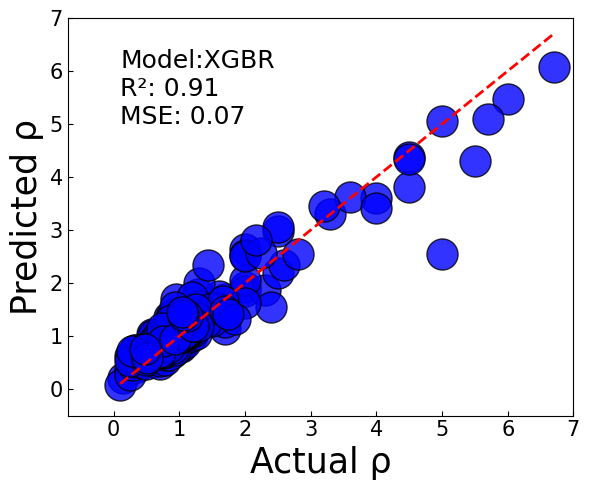

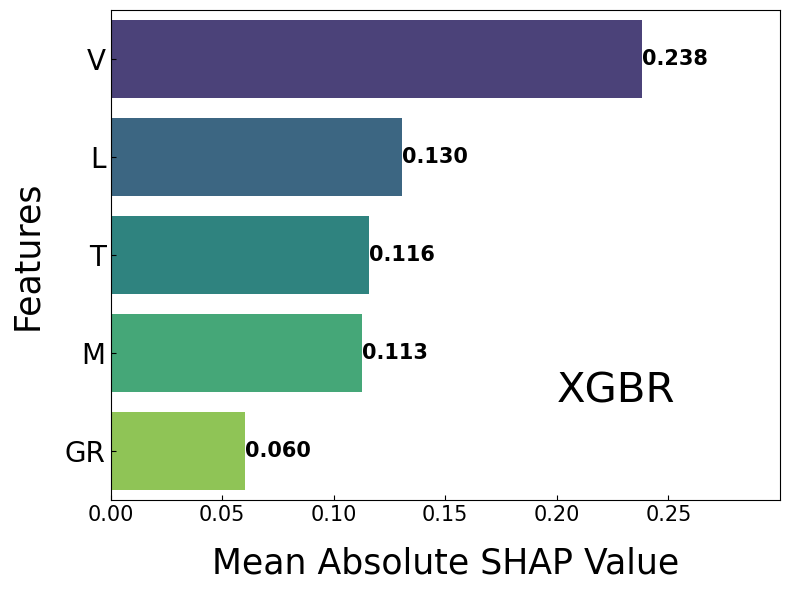

In [12]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
import xgboost as xgb


# Load data
validate_data = pd.read_excel('Integrated dataset.xlsx')


# Data preprocessing
columns = ['metal', 'support', 'wt.%', 'solid electrolyte', 'ionic species', 'ionic species charge', 
           'particle size(nm)', 'metal loading (mg)', 'catalyst redox', 'CO2:H2 ratio', 'temp(℃)', 
           'rCO(mol/s)', 'voltage(V)', 'current(mA)', 'ρCO', 'ΛCO']

# Validation data preprocessing
validate_data.columns = columns
validate_data['metal'] = validate_data['metal'].replace(['Fe','Co','Ni','Cu','ZnO','Ru','Rh','Pd','Pt'],
                                                        [55.8, 58.9, 58.7, 63.5, 65.4, 101.1, 102.9, 106.4, 195.1])
validate_data['wt.%'] = validate_data['wt.%'].fillna(100).astype(float)
validate_data['gas ratio'] = validate_data['CO2:H2 ratio'].apply(lambda x: int(x.split(':')[0]) / int(x.split(':')[1]))
validate_data = validate_data.drop('CO2:H2 ratio', axis=1)
validate_data.columns = ['M', 'S', 'WT', 'SE', 'IS', 'ISC', 'PS', 'L', 'CR', 'T', 'RR', 'V', 'C', 'ρ', 'Λ', 'GR']

ionic_charge = {
    'O2-': -2,
    'H+': 1,
    'Li+': 1,
    'Na+': 1,
    'K+': 1,
    'none': 0
}
validate_data['IS_charge'] = validate_data['IS'].replace(ionic_charge).fillna(0).astype(float)

def electro_class(row):
    if row['V'] > 0 and row['ρ'] >= 1:
        return 0
    elif row['V'] < 0 and row['ρ'] >= 1:
        return 1
    elif row['V'] > 0 and row['ρ'] <= 1:
        return 1
    elif row['V'] < 0 and row['ρ'] <= 1:
        return 0
    else:
        return 'undefined'

validate_data['BH'] = validate_data.apply(electro_class, axis=1)

# Feature and target selection
features = ['M', 'L', 'V', 'T', 'GR']
X_v = validate_data[features]
y_v = validate_data['ρ']

# Feature scaling
scaler = StandardScaler()
X_v_scaled = scaler.fit_transform(X_v)

XGBR = xgb.XGBRegressor(n_estimators=30, max_depth=6, eta=0.3, subsample=0.5, colsample_bytree=0.5, objective='reg:squarederror', random_state=0)
XGBR.fit(X_v_scaled, y_v)
y_pred = XGBR.predict(X_v_scaled)

# plot the scatters with RFR
mse = mean_squared_error(y_v, y_pred)
r2 = r2_score(y_v, y_pred)
    
fig = plt.figure(figsize=(6,5))
plt.scatter(y_v, y_pred, alpha=0.8, color='blue', edgecolors='k', s=500)
plt.plot([y_v.min(), y_v.max()], [y_v.min(), y_v.max()], 'r--', lw=2)
plt.xlabel('Actual ρ', size=25)
plt.ylabel('Predicted ρ', size=25)
plt.text(0.1, 5, f'Model:XGBR\nR²: {r2:.2f}\nMSE: {mse:.2f}', fontsize=18)
plt.tick_params(direction='in', which='both', labelsize=15)

plt.xlim(-0.7, 7)
plt.ylim(-0.5, 7)
plt.xticks(np.arange(0, 7.1, 1))
plt.yticks(np.arange(0, 7.1, 1))

plt.tight_layout()
plt.savefig('Integrated Validate Scatter (XGBR only).jpg', format='jpeg', dpi=600)
plt.show

# feature importance for XGBR
import shap
shap.initjs()
# Create the explainer using TreeExplainer
XGBR_explainer = shap.TreeExplainer(XGBR)
XGBR_shap_values = XGBR_explainer.shap_values(X_v_scaled)

# Generating the bar plot with mean SHAP values and feature names
# Calculate mean absolute SHAP values for each feature
mean_abs_shap_values = np.mean(np.abs(XGBR_shap_values), axis=0)

# Create a DataFrame for plotting with SHAP values
importance_df = pd.DataFrame({'Feature': X_v.columns, 'Importance': mean_abs_shap_values})
importance_df = importance_df.sort_values(by='Importance', ascending=False)
# Plotting the feature importances with values
plt.figure(figsize=(8, 6))
sns.barplot(x='Importance', y='Feature', data=importance_df, palette='viridis')
# Adding the values on the bars
for index, value in enumerate(importance_df['Importance']):
    plt.text(value, index, f'{value:.3f}', va='center', ha='left', color='black', fontweight='bold', fontsize=15)

plt.xlim(0,0.3)
plt.xlabel('Mean Absolute SHAP Value', size=25, labelpad=15)
plt.ylabel('Features', size=25, labelpad=15)
plt.tick_params(axis='x', direction='in', labelsize=15)
plt.tick_params(axis='y', direction='in', labelsize=20)
plt.text(0.2, len(importance_df) - 1.5, 'XGBR', fontsize=30)
plt.gca().xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x:.2f}'))
plt.gca().xaxis.set_ticks(np.arange(0, 0.26, 0.05))
plt.tight_layout()
plt.savefig('Integrated XGBR Feature Importance.jpg', format='jpeg', dpi=600)
plt.show()

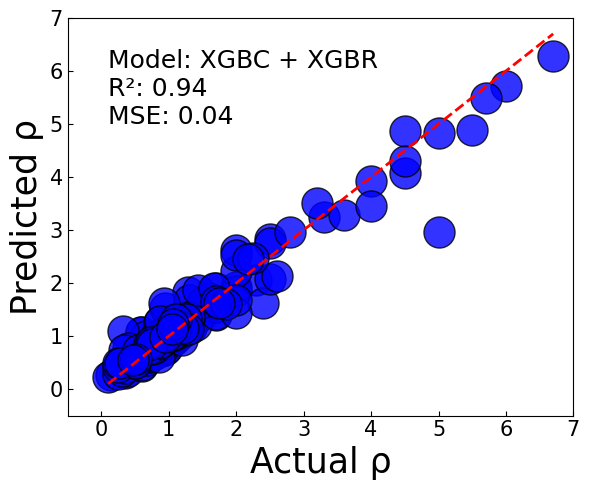

In [17]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
import xgboost as xgb

# Load data
validate_data = pd.read_excel('Integrated dataset.xlsx')

# Data preprocessing
columns = ['metal', 'support', 'wt.%', 'solid electrolyte', 'ionic species', 'ionic species charge', 
           'particle size(nm)', 'metal loading (mg)', 'catalyst redox', 'CO2:H2 ratio', 'temp(℃)', 
           'rCO(mol/s)', 'voltage(V)', 'current(mA)', 'ρCO', 'ΛCO']

# Validation data preprocessing
validate_data.columns = columns
validate_data['metal'] = validate_data['metal'].replace(['Fe','Co','Ni','Cu','ZnO','Ru','Rh','Pd','Pt'],
                                                        [55.8, 58.9, 58.7, 63.5, 65.4, 101.1, 102.9, 106.4, 195.1])
validate_data['support'] = validate_data['support'].fillna(0)
validate_data['support'] = validate_data['support'].replace(['Co3O4','ZnO','YSZ','α-Al2O3','CNF'],['1','2','3','4','5']).astype(int)
validate_data['ionic species'] = validate_data['ionic species'].replace(['O2-','H+','Li+','Na+','K+'],['-2','1','2','3','4']).astype(int)
validate_data['wt.%'] = validate_data['wt.%'].fillna(100).astype(float)
validate_data['gas ratio'] = validate_data['CO2:H2 ratio'].apply(lambda x: int(x.split(':')[0]) / int(x.split(':')[1]))
validate_data = validate_data.drop('CO2:H2 ratio', axis=1)
validate_data.columns = ['M', 'S', 'WT', 'SE', 'IS', 'ISC', 'PS', 'L', 'CR', 'T', 'RR', 'V', 'C', 'ρ', 'Λ', 'GR']

def electro_class(row):
    if row['V'] > 0 and row['ρ'] >= 1:
        return 0
    elif row['V'] < 0 and row['ρ'] >= 1:
        return 1
    elif row['V'] > 0 and row['ρ'] <= 1:
        return 1
    elif row['V'] < 0 and row['ρ'] <= 1:
        return 0
    else:
        return 'undefined'

validate_data['BH'] = validate_data.apply(electro_class, axis=1)

# Feature and target selection
features = ['M', 'S', 'L', 'IS', 'V', 'T', 'GR']
X_v = validate_data[features]
y_v = validate_data['BH']

# XGBC + XGBR
XGBC = xgb.XGBClassifier(n_estimators=10, eta=0.3, max_depth=4, colsample_bytree=1, subsample=1, random_state=0)
XGBC.fit(X_v, y_v)
y_pred_class = XGBC.predict(X_v)

# Add classification results as a new feature
validate_data['BH'] = y_pred_class

# Prepare data for regression
features_reg = ['M', 'L', 'T', 'V', 'GR', 'BH']
X_v_reg = validate_data[features_reg]
y_v_reg = validate_data['ρ']
# Feature scaling
scaler = StandardScaler()
X_v_reg_scaled = scaler.fit_transform(X_v_reg)

XGBR = xgb.XGBRegressor(n_estimators=30, max_depth=6, eta=0.3, subsample=0.5, colsample_bytree=0.5, random_state=0)
XGBR.fit(X_v_reg_scaled, y_v_reg)
y_reg_pred = XGBR.predict(X_v_reg_scaled)

# plot the scatters with XGBR
mse = mean_squared_error(y_v_reg, y_reg_pred)
r2 = r2_score(y_v_reg, y_reg_pred)
    
fig = plt.figure(figsize=(6,5))
plt.scatter(y_v_reg, y_reg_pred, alpha=0.8, color='blue', edgecolors='k', s=500)
plt.plot([y_v_reg.min(),y_v_reg.max()], [y_v_reg.min(), y_v_reg.max()], 'r--', lw=2)
plt.xlabel('Actual ρ', size=25)
plt.ylabel('Predicted ρ', size=25)
plt.text(0.1, 5, f'Model: XGBC + XGBR\nR²: {r2:.2f}\nMSE: {mse:.2f}', fontsize=18)
plt.tick_params(direction='in', which='both', labelsize=15)

plt.xlim(-0.5, 7)
plt.ylim(-0.5, 7)
plt.xticks(np.arange(0, 7.1, 1))
plt.yticks(np.arange(0, 7.1, 1))

plt.tight_layout()
plt.savefig('Integrated Validate Scatter (XGBC + XGBR).jpg', format='jpeg', dpi=600)
plt.show()

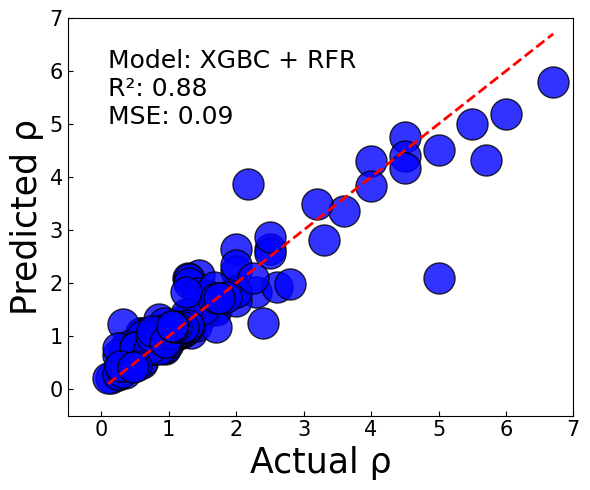

In [19]:
# XGBC + RFR
XGBC = xgb.XGBClassifier(n_estimators=10, eta=0.3, max_depth=4, colsample_bytree=1, subsample=1, random_state=0)
XGBC.fit(X_v, y_v)
y_pred_class = XGBC.predict(X_v)

# Add classification results as a new feature
validate_data['BH'] = y_pred_class

# Prepare data for regression
features_reg = ['M', 'L', 'T', 'V', 'GR', 'BH']
X_v_reg = validate_data[features_reg]
y_v_reg = validate_data['ρ']
# Feature scaling
scaler = StandardScaler()
X_v_reg_scaled = scaler.fit_transform(X_v_reg)

# plot the scatters with RFR
RFR = RandomForestRegressor(n_estimators=10, max_depth=7, min_samples_split=2, random_state=0)
RFR.fit(X_v_reg_scaled, y_v_reg)
y_reg_pred = RFR.predict(X_v_reg_scaled)

# plot the scatters with RFR
mse = mean_squared_error(y_v_reg, y_reg_pred)
r2 = r2_score(y_v_reg, y_reg_pred)
    
fig = plt.figure(figsize=(6,5))
plt.scatter(y_v_reg, y_reg_pred, alpha=0.8, color='blue', edgecolors='k', s=500)
plt.plot([y_v_reg.min(),y_v_reg.max()], [y_v_reg.min(), y_v_reg.max()], 'r--', lw=2)
plt.xlabel('Actual ρ', size=25)
plt.ylabel('Predicted ρ', size=25)
plt.text(0.1, 5, f'Model: XGBC + RFR\nR²: {r2:.2f}\nMSE: {mse:.2f}', fontsize=18)
plt.tick_params(direction='in', which='both', labelsize=15)

plt.xlim(-0.5, 7)
plt.ylim(-0.5, 7)
plt.xticks(np.arange(0, 7.1, 1))
plt.yticks(np.arange(0, 7.1, 1))

plt.tight_layout()
plt.savefig('Integrated Validate Scatter (XGBC + RFR).jpg', format='jpeg', dpi=600)
plt.show()

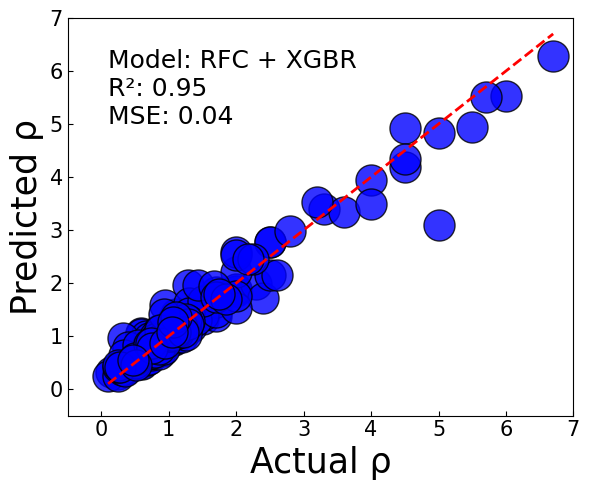

In [20]:
# RFC + XGBR
RFC = RandomForestClassifier(n_estimators=10, max_depth=6, min_samples_split=2, random_state=0)
RFC.fit(X_v, y_v)
y_pred_class = RFC.predict(X_v)

# Add classification results as a new feature
validate_data['BH'] = y_pred_class

# Prepare data for regression
features_reg = ['M', 'L', 'T', 'V', 'GR', 'BH']
X_v_reg = validate_data[features_reg]
y_v_reg = validate_data['ρ']
# Feature scaling
scaler = StandardScaler()
X_v_reg_scaled = scaler.fit_transform(X_v_reg)

XGBR = xgb.XGBRegressor(n_estimators=30, max_depth=6, eta=0.3, subsample=0.5, colsample_bytree=0.5, random_state=0)
XGBR.fit(X_v_reg_scaled, y_v_reg)
y_reg_pred = XGBR.predict(X_v_reg_scaled)

# plot the scatters with XGBR
mse = mean_squared_error(y_v_reg, y_reg_pred)
r2 = r2_score(y_v_reg, y_reg_pred)
    
fig = plt.figure(figsize=(6,5))
plt.scatter(y_v_reg, y_reg_pred, alpha=0.8, color='blue', edgecolors='k', s=500)
plt.plot([y_v_reg.min(),y_v_reg.max()], [y_v_reg.min(), y_v_reg.max()], 'r--', lw=2)
plt.xlabel('Actual ρ', size=25)
plt.ylabel('Predicted ρ', size=25)
plt.text(0.1, 5, f'Model: RFC + XGBR\nR²: {r2:.2f}\nMSE: {mse:.2f}', fontsize=18)
plt.tick_params(direction='in', which='both', labelsize=15)

plt.xlim(-0.5, 7)
plt.ylim(-0.5, 7)
plt.xticks(np.arange(0, 7.1, 1))
plt.yticks(np.arange(0, 7.1, 1))

plt.tight_layout()
plt.savefig('Integrated Validate Scatter (RFC + XGBR).jpg', format='jpeg', dpi=600)
plt.show()

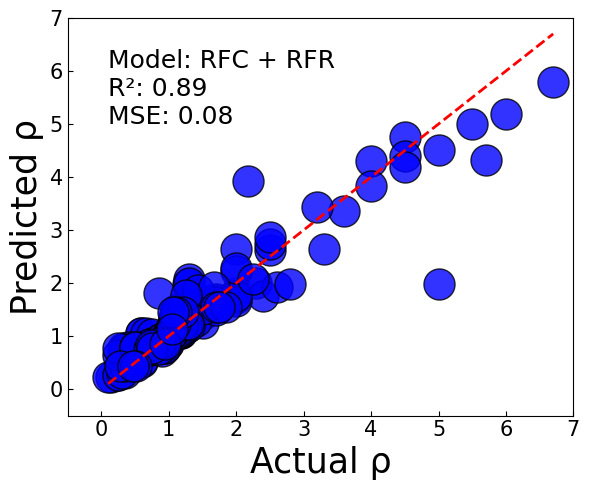

In [21]:
# RFC + RFR
RFC = RandomForestClassifier(n_estimators=10, max_depth=6, min_samples_split=2, random_state=0)
RFC.fit(X_v, y_v)
y_pred_class = RFC.predict(X_v)

# Add classification results as a new feature
validate_data['BH'] = y_pred_class

# Prepare data for regression
features_reg = ['M', 'L', 'T', 'V', 'GR', 'BH']
X_v_reg = validate_data[features_reg]
y_v_reg = validate_data['ρ']
# Feature scaling
scaler = StandardScaler()
X_v_reg_scaled = scaler.fit_transform(X_v_reg)

RFR = RandomForestRegressor(n_estimators=10, max_depth=7, min_samples_split=2, random_state=0)
RFR.fit(X_v_reg_scaled, y_v_reg)
y_reg_pred = RFR.predict(X_v_reg_scaled)

# plot the scatters with RFR
mse = mean_squared_error(y_v_reg, y_reg_pred)
r2 = r2_score(y_v_reg, y_reg_pred)
    
fig = plt.figure(figsize=(6,5))
plt.scatter(y_v_reg, y_reg_pred, alpha=0.8, color='blue', edgecolors='k', s=500)
plt.plot([y_v_reg.min(),y_v_reg.max()], [y_v_reg.min(), y_v_reg.max()], 'r--', lw=2)
plt.xlabel('Actual ρ', size=25)
plt.ylabel('Predicted ρ', size=25)
plt.text(0.1, 5, f'Model: RFC + RFR\nR²: {r2:.2f}\nMSE: {mse:.2f}', fontsize=18)
plt.tick_params(direction='in', which='both', labelsize=15)

plt.xlim(-0.5, 7)
plt.ylim(-0.5, 7)
plt.xticks(np.arange(0, 7.1, 1))
plt.yticks(np.arange(0, 7.1, 1))

plt.tight_layout()
plt.savefig('Integrated Validate Scatter (RFC + RFR).jpg', format='jpeg', dpi=600)
plt.show()